In [ ]:
# Article: Introduction to Quantum Programming with Qiskit
# reference: https://blog.mlq.ai/quantum-programming-with-qiskit/

In [2]:
import qiskit as q
%matplotlib inline

In [3]:
# build a 2 qubit, 2 classical circuit
circuit = q.QuantumCircuit(2,2)

In [6]:
# apply a NOT gate to qubit 0, currently 0,0
circuit.x(0)
# now 10

In [7]:
# apply a CNOT gate, which flips 2nd qubit value if first qubit is a 1
circuit.cx(0, 1)
# now 11

In [8]:
# take the measurement
circuit.measure([0, 1], [0, 1])

In [9]:
# visual representation of the circuit
circuit.draw()

┌───┐          ┌───┐     ┌─┐   
q_0: ┤ X ├──■────■──┤ X ├──■──┤M├───
     └───┘┌─┴─┐┌─┴─┐└───┘┌─┴─┐└╥┘┌─┐
q_1: ─────┤ X ├┤ X ├─────┤ X ├─╫─┤M├
          └───┘└───┘     └───┘ ║ └╥┘
c: 2/══════════════════════════╩══╩═
                               0  1

In [24]:
from qiskit.visualization import plot_bloch_multivector
from qiskit.visualization import plot_histogram

In [25]:
from qiskit import transpile, assemble
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram

def run_job(circuit):
    # Select the statevector simulator
    state_simulator = Aer.get_backend('statevector_simulator')

    # Transpile the circuit for the simulator
    transpiled_circuit = transpile(circuit, state_simulator)

    # Run the circuit on the statevector simulator
    job = state_simulator.run(transpiled_circuit)
    result = job.result()

    # Get statevector
    statevec = result.get_statevector()

    # Add measurement before running on QASM simulator
    circuit.measure_all()

    # Select the QASM simulator
    qasm_simulator = Aer.get_backend('qasm_simulator')

    # Transpile for the QASM simulator
    transpiled_circuit_qasm = transpile(circuit, qasm_simulator)

    # Run the circuit on the QASM simulator (with measurements)
    qasm_job = qasm_simulator.run(transpiled_circuit_qasm, shots=1024)
    qasm_result = qasm_job.result()

    # Get measurement counts
    counts = qasm_result.get_counts()

    return statevec, counts


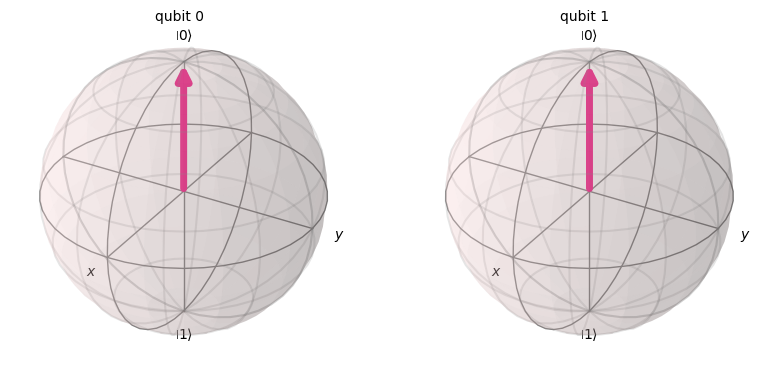

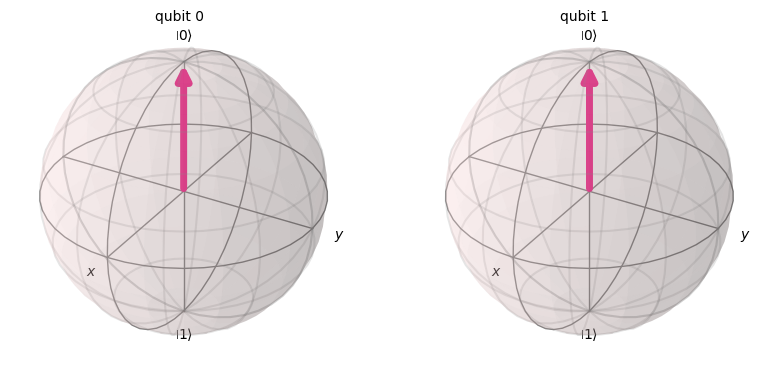

In [26]:
circuit = q.QuantumCircuit(2,2)
statevec, counts = run_job(circuit)
plot_bloch_multivector(statevec)

Statevector: Statevector([0.70710678+0.j, 0.        +0.j, 0.        +0.j,
             0.70710678+0.j],
            dims=(2, 2))
Measurement Counts: {'00': 503, '11': 521}


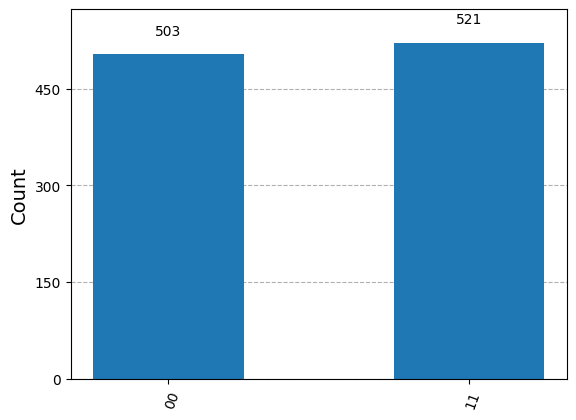

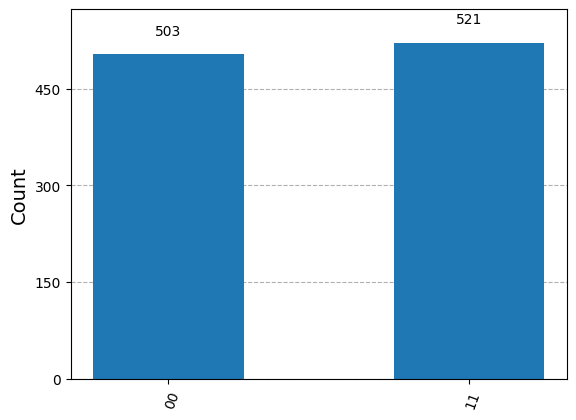

In [23]:
from qiskit import QuantumCircuit

# Create a simple circuit
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)

# Run the job
statevec, counts = run_job(qc)

# Print results
print("Statevector:", statevec)
print("Measurement Counts:", counts)

# Plot the histogram of measurement results
plot_histogram(counts)


Graph for Max-Cut:


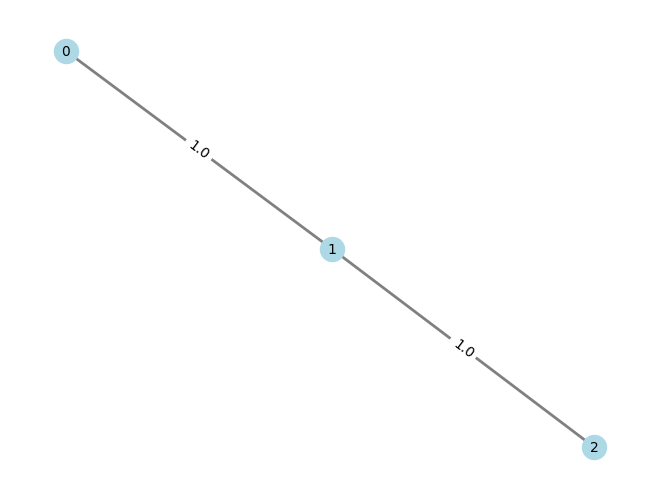


Quadratic Program:
Problem name: Max-Cut

Maximize
  -2*x_0*x_1 - 2*x_1*x_2 + x_0 + 2*x_1 + x_2

Subject to
  No constraints

  Binary variables (3)
    x_0 x_1 x_2


Running QAOA...

--- QAOA Results ---
Optimal solution found: [0. 1. 0.]
Optimal objective value: 2.0
Solution interpreted as node partitions:
  Set 1 (nodes with value 1): [1]
  Set 2 (nodes with value 0): [0, 2]
  Number of cuts in the solution: 2.0

--- End of Demonstration ---


/tmp/ipykernel_1447/1494512982.py:109: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


In [1]:
# Import necessary Qiskit libraries

# For creating and manipulating quantum circuits
from qiskit import QuantumCircuit, transpile
from qiskit.providers.basic_provider import BasicSimulator # BasicAer simulator is deprecated

# For quantum algorithms like QAOA and classical optimizers
from qiskit_algorithms import QAOA, SamplingVQE # QAOA is a specific type of VQE (Variational Quantum Eigensolver)
from qiskit_algorithms.optimizers import COBYLA # A classical optimizer (Constrained Optimization BY Linear Approximation)
from qiskit.primitives import Sampler # Primitives for running algorithms

# For defining and solving optimization problems
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization import QuadraticProgram # To define the optimization problem
from qiskit_optimization.converters import QuadraticProgramToQubo # To convert to QUBO form, suitable for QAOA

# For graph visualization (optional, but helpful)
import networkx as nx
import matplotlib.pyplot as plt

# --- 1. Define the Optimization Problem (Max-Cut) ---

# Let's define a simple graph with 3 nodes and 2 edges
# Nodes: 0, 1, 2
# Edges: (0,1) and (1,2)
# We want to partition these nodes into two sets (e.g., set A and set B)
# such that the number of edges connecting a node in set A to a node in set B is maximized.

num_nodes = 3
# Edges are defined as a list of tuples (node1, node2, weight)
# For unweighted Max-Cut, weight is typically 1.
edges = [(0, 1, 1.0), (1, 2, 1.0)]

# Create a graph object (optional, for visualization and understanding)
G = nx.Graph()
G.add_nodes_from(range(num_nodes))
G.add_weighted_edges_from(edges)

# Visualize the graph (optional)
print("Graph for Max-Cut:")
pos = nx.spring_layout(G) # positions for all nodes
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', width=2, font_size=10)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
plt.show()


# --- 2. Convert the Max-Cut problem to a Quadratic Program ---

# A Quadratic Program (QP) is a standard way to represent optimization problems.
# For Max-Cut, we can formulate it as a QUBO (Quadratic Unconstrained Binary Optimization) problem.
# Let x_i be a binary variable, 0 or 1, representing which set node i belongs to.
# The objective is to maximize sum(w_ij * (x_i * (1-x_j) + (1-x_i) * x_j)) for each edge (i,j) with weight w_ij.
# This can be rewritten as minimizing -sum(w_ij * (x_i - x_j)^2) + constant,
# or more commonly as minimizing sum(w_ij * (1 - z_i * z_j))/2 where z_i = 2*x_i - 1 (Ising variables).
# Qiskit Optimization handles this conversion.

# Create an empty quadratic program
qp = QuadraticProgram(name="Max-Cut")

# Add binary variables, one for each node
for i in range(num_nodes):
    qp.binary_var(name=f'x_{i}')

# Define the objective function to maximize.
# For an edge (i, j), the term x_i + x_j - 2*x_i*x_j contributes to the cut if x_i != x_j.
# Or, (x_i - x_j)^2 = x_i^2 - 2x_i x_j + x_j^2. Since x_i is binary, x_i^2 = x_i.
# So, (x_i - x_j)^2 = x_i + x_j - 2x_i x_j.
# We want to maximize Sum_{edges (i,j)} w_ij * (x_i + x_j - 2*x_i*x_j)
linear = {} # Linear terms: {variable_name: coefficient}
quadratic = {} # Quadratic terms: {(var1_name, var2_name): coefficient}

for u, v, weight in edges:
    # x_u * (1 - x_v) contributes 'weight' if x_u=1 and x_v=0
    # (1 - x_u) * x_v contributes 'weight' if x_u=0 and x_v=1
    # This is equivalent to w * (x_u + x_v - 2 * x_u * x_v)
    var_u = f'x_{u}'
    var_v = f'x_{v}'
    
    # Add linear terms
    linear[var_u] = linear.get(var_u, 0) + weight
    linear[var_v] = linear.get(var_v, 0) + weight
    
    # Add quadratic terms
    # The tuple for quadratic keys should be in a canonical order (e.g., sort variable indices)
    # However, qiskit_optimization handles ('x_0', 'x_1') and ('x_1', 'x_0') correctly.
    if (var_u, var_v) in quadratic:
        quadratic[(var_u, var_v)] -= 2 * weight
    elif (var_v, var_u) in quadratic:
        quadratic[(var_v, var_u)] -= 2 * weight
    else:
        quadratic[(var_u, var_v)] = -2 * weight
        
qp.maximize(linear=linear, quadratic=quadratic)
print("\nQuadratic Program:")
print(qp.prettyprint())

# --- 3. Set up the QAOA Algorithm ---

# QAOA requires a classical optimizer and a quantum backend (simulator or real hardware).
# We will use a classical simulator here.

# Choose a classical optimizer
# COBYLA is a good general-purpose optimizer that doesn't require gradients.
optimizer = COBYLA(maxiter=100) # maxiter = maximum number of iterations

# Choose a quantum backend (simulator)
# We use Qiskit Primitives (Sampler) for algorithm execution
sampler = Sampler()

# Instantiate QAOA
# `reps` is the number of layers in the QAOA ansatz (p in standard QAOA notation)
# More reps can lead to better results but increase circuit depth.
qaoa_mes = QAOA(sampler=sampler, optimizer=optimizer, reps=1) # `reps=1` for a simple ansatz

# --- 4. Use MinimumEigenOptimizer to Solve the Problem with QAOA ---

# MinimumEigenOptimizer is a Qiskit Optimization class that wraps quantum algorithms
# like VQE or QAOA to find the minimum (or maximum) of an optimization problem.
# It handles the conversion of the problem to an operator (Hamiltonian) that QAOA can understand.
algorithm = MinimumEigenOptimizer(min_eigen_solver=qaoa_mes)

# Solve the quadratic program
print("\nRunning QAOA...")
result = algorithm.solve(qp)

# --- 5. Print and Interpret the Results ---

print("\n--- QAOA Results ---")
if result.status.name == "SUCCESS":
    print(f"Optimal solution found: {result.x}") # Array of binary values [x_0, x_1, ...]
    print(f"Optimal objective value: {result.fval}")
    print(f"Solution interpreted as node partitions:")
    
    partition1 = [i for i, val in enumerate(result.x) if val == 1]
    partition2 = [i for i, val in enumerate(result.x) if val == 0]
    
    print(f"  Set 1 (nodes with value 1): {partition1}")
    print(f"  Set 2 (nodes with value 0): {partition2}")
    
    # Calculate the number of cuts for this solution
    cuts = 0
    for u, v, weight in edges:
        if result.x[u] != result.x[v]:
            cuts += weight
    print(f"  Number of cuts in the solution: {cuts}")

    # For Max-Cut, the fval from qp.maximize(...) should be equal to the number of cuts.
    # If qp.minimize(...) was used with an Ising formulation, fval would be the energy.

    # You can also access the underlying quantum result if needed
    # print(f"Optimizer raw results: {result.min_eigen_solver_result}")
else:
    print(f"Optimization did not succeed. Status: {result.status.name}")
    print(f"Message: {result.message}")

# (Optional) Verify with a classical exact solver for small problems
# from qiskit_optimization.algorithms import CplexOptimizer # Requires CPLEX installation
# try:
#     exact_solver = CplexOptimizer()
#     exact_result = exact_solver.solve(qp)
#     print("\n--- Classical Exact Solver Results (for comparison) ---")
#     print(f"Optimal solution: {exact_result.x}")
#     print(f"Optimal objective value: {exact_result.fval}")
# except Exception as e:
#     print(f"\nCould not run classical exact solver (CPLEX might not be installed): {e}")

print("\n--- End of Demonstration ---")